# Keras and Autoencoder

This code is based on this notebook https://github.com/naokishibuya/deep-learning/blob/master/python/autoencoder_noise_reduction.ipynb

Another cool tutorial https://blog.keras.io/building-autoencoders-in-keras.html

In case you don't know anything about CNNs https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/

In [1]:
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/damien/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## MNIST

Database for handwritten digits made by Yann Lecun

In [2]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

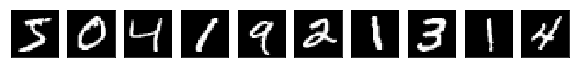

In [3]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten

X_train = preprocess(X_train)
X_test  = preprocess(X_test)

# also create a validation set for training
X_train, X_valid = train_test_split(X_train, test_size=0.3)

## Convolutional Autoencoder

Let's present what is an autoencoder

<img src="https://cdn-images-1.medium.com/max/1000/1*j_y0bNZLP1yzqtyF48Z3Ug.png">


Now we are going to define our model

In [5]:
n_epochs = 100
batch_size = 128

In [6]:
def convolutional_autoencoder():
    # encoding
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # decoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    
    return autoencoder

def get_callbacks(model_filepath, log_dir, patience=10):
    earlystopping = EarlyStopping('val_loss', patience=patience, mode="min")
    checkpointer = ModelCheckpoint(filepath=model_filepath,
                               verbose=0,
                               save_best_only=True)
    tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)
    return [earlystopping, checkpointer, tensorboard]

file_path_feed_forward = ".model_weights_conv_autoe.hdf5"
log_dir_feed_forward = './logs/conv_autoe'
callbacks_feed_forward = get_callbacks(file_path_feed_forward, log_dir_feed_forward, patience=10)

Before anything, we need reshape our data to the format that our model expects.

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

In [8]:
autoencoder = convolutional_autoencoder()
autoencoder.fit(
    X_train, X_train, 
    epochs=n_epochs, 
    batch_size=batch_size, 
    validation_data=(X_valid, X_valid), 
    callbacks=callbacks_feed_forward
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

KeyboardInterrupt: 

In [ ]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
X_test_decoded = autoencoder.predict(X_test)

show_images(X_test, X_test_decoded)

In [ ]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train, 0.5)
X_valid_noisy = add_noise(X_valid, 0.5)
X_test_noisy  = add_noise(X_test, 0.5)

In [ ]:
noise_autoencoder = convolutional_autoencoder()
noise_autoencoder.fit(
    X_train_noisy, X_train, 
    epochs=batch_size, 
    batch_size=batch_size, 
    validation_data=(X_valid_noisy, X_valid)
)

In [ ]:
X_test_decoded = noise_autoencoder.predict(X_test_noisy)

show_images(X_test_noisy, X_test_decoded)

An interesting to test is the following :

In [ ]:
X_test_decoded = autoencoder.predict(X_test_noisy)

show_images(X_test_noisy, X_test_decoded)